# Comparison of dgemm calls performed within HPL and in a calibration

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'dgemm_prediction/2/grenoble_2019-07-24_1876425.zip'

def read_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    return df

traces = read_archive(archive, 2)

traces = traces[(traces['function'] == 'dgemm') & (traces['rank'] == 0)].reset_index(drop=True)
traces.m = traces.m.astype(int)
traces.n = traces.n.astype(int)
traces.k = traces.k.astype(int)
print(len(traces))
traces.head()

Read trace n°2 from dgemm_prediction/2/grenoble_2019-07-24_1876425.zip: 4088143 lines
7834


,jobid,function,start,end,rank,m,n,k,duration,exp_id
0,1876425,dgemm,0.090370,0.090415,0,6654,2,2,0.000045,2
1,1876425,dgemm,0.090573,0.090627,0,6652,4,4,0.000054,2
2,1876425,dgemm,0.090764,0.090785,0,6650,2,2,0.000022,2
3,1876425,dgemm,0.090929,0.091052,0,6648,8,8,0.000122,2
4,1876425,dgemm,0.091207,0.091229,0,6646,2,2,0.000022,2


In [3]:
traces_calibration = pandas.read_hdf('../../../g5k_data/data.db', where=['node == 1', 'start_time > 1564000000', 'start_time < 1565000000'])
traces_calibration = traces_calibration[(traces_calibration['core'] == 0) & (traces_calibration['expfile_hash'] == '502bbead210ef50896e586113f5f3a1ce32ffb0525a0294af45382842eb8c25c')]
traces_calibration = traces_calibration.reset_index(drop=True)
print(len(traces_calibration))
traces_calibration.head()

7834


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash
0,dgemm,6654,2,2,382.179623,0.000021,0,1,dahu,1876538,0,1564052852,0,502bbead210ef50896e586113f5f3a1ce32ffb0525a029...
1,dgemm,6652,4,4,382.179668,0.000048,0,1,dahu,1876538,0,1564052852,1,502bbead210ef50896e586113f5f3a1ce32ffb0525a029...
2,dgemm,6650,2,2,382.179719,0.000021,0,1,dahu,1876538,0,1564052852,2,502bbead210ef50896e586113f5f3a1ce32ffb0525a029...
3,dgemm,6648,8,8,382.179742,0.000102,0,1,dahu,1876538,0,1564052852,3,502bbead210ef50896e586113f5f3a1ce32ffb0525a029...
4,dgemm,6646,2,2,382.179847,0.000021,0,1,dahu,1876538,0,1564052852,4,502bbead210ef50896e586113f5f3a1ce32ffb0525a029...


In [4]:
sizelist_hpl = [list(t[1]) for t in traces[['m', 'n', 'k']].iterrows()]
sizelist_cal = [list(t[1]) for t in traces_calibration[['m', 'n', 'k']].iterrows()]
assert sizelist_hpl == sizelist_cal

In [5]:
traces['duration_calibration'] = traces_calibration['duration']
traces['mnk'] = traces.m * traces.n * traces.k

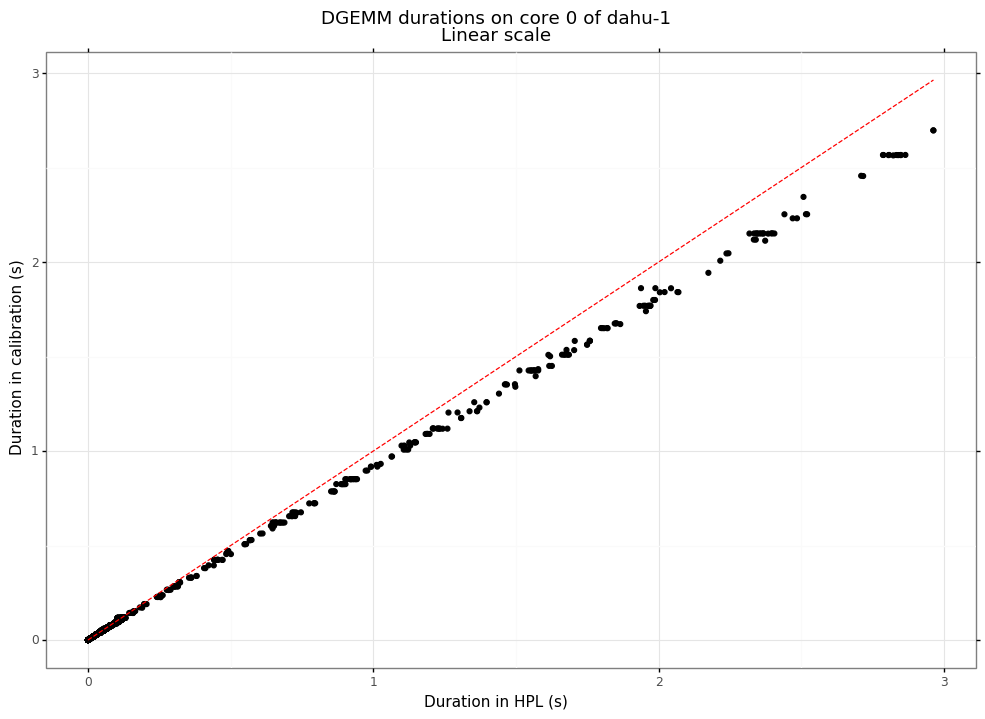

<ggplot: (-9223363265295937301)>


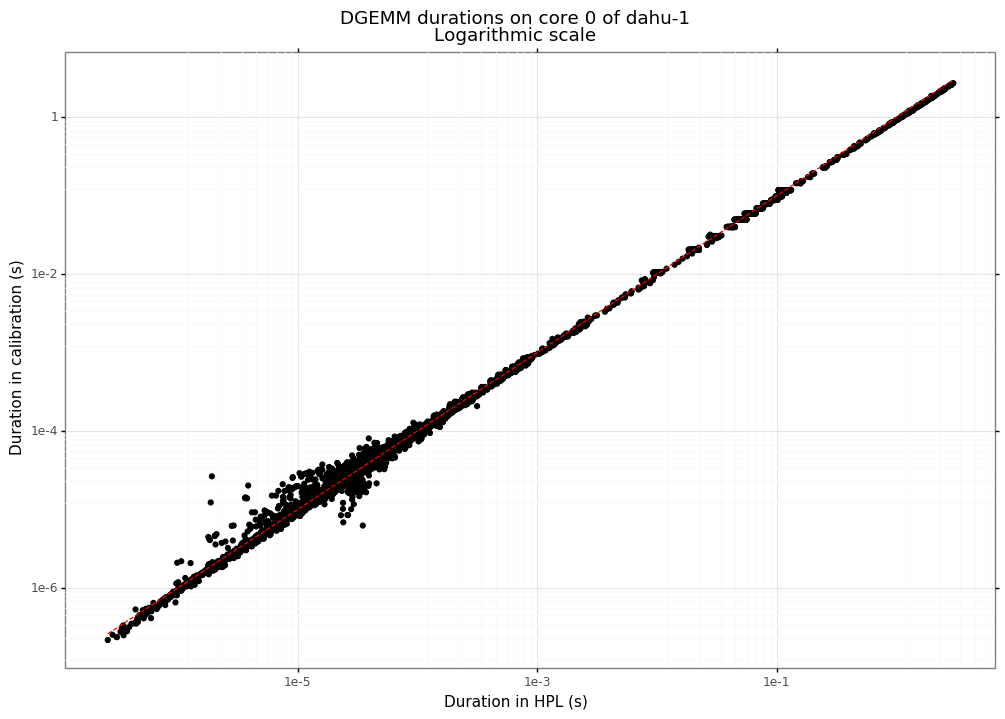

<ggplot: (-9223363265295993358)>


In [6]:
plot = ggplot(traces, aes(x='duration', y='duration_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='duration', y='duration'), color='red', linetype='dashed')
plot = plot + xlab('Duration in HPL (s)') + ylab('Duration in calibration (s)')
title = 'DGEMM durations on core 0 of dahu-1\n'
print(plot + ggtitle(title + 'Linear scale'))
print(plot + scale_x_log10() + scale_y_log10() + ggtitle(title + 'Logarithmic scale'))

In [7]:
traces['gflops_hpl'] = 2*traces.mnk / traces['duration'] * 1e-9
traces['gflops_calibration'] = 2*traces.mnk / traces['duration_calibration'] * 1e-9

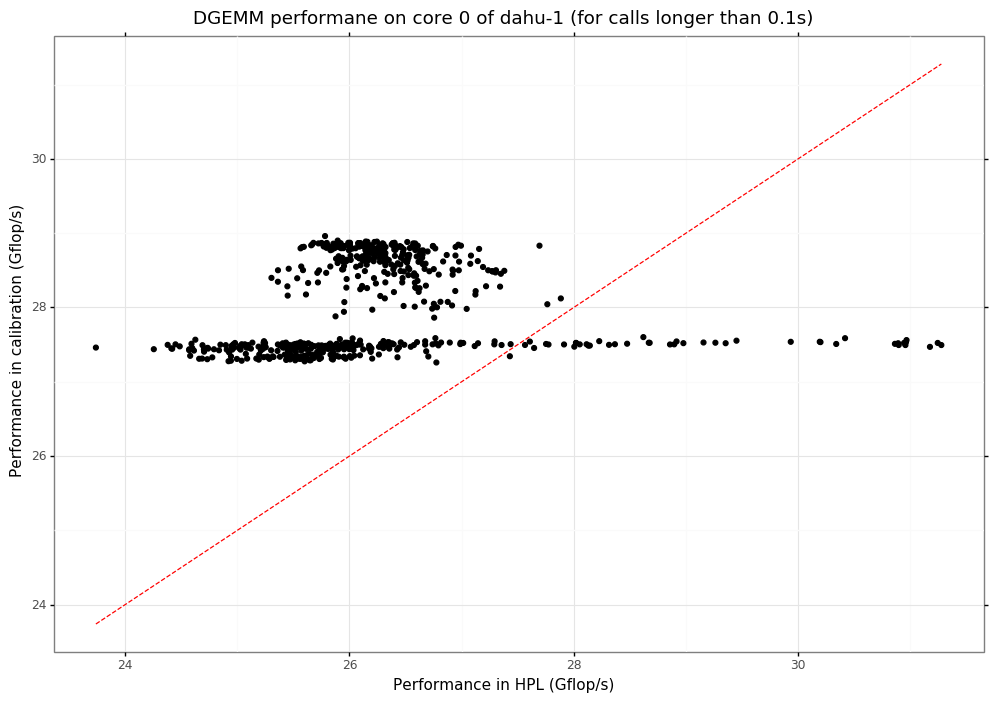

<ggplot: (-9223363265295984489)>

In [8]:
plot = ggplot(traces[traces.duration > 0.1], aes(x='gflops_hpl', y='gflops_calibration')) + theme_bw() + geom_point() + geom_line(aes(x='gflops_hpl', y='gflops_hpl'), color='red', linetype='dashed')
plot = plot + xlab('Performance in HPL (Gflop/s)') + ylab('Performance in calibration (Gflop/s)')
plot + ggtitle('DGEMM performane on core 0 of dahu-1 (for calls longer than 0.1s)')

In [9]:
summary = traces[['duration', 'duration_calibration', 'mnk']].sum()
summary['gflops'] = 2*summary['mnk'] / summary['duration'] * 1e-9
summary['gflops_calibration'] = 2*summary['mnk'] / summary['duration_calibration'] * 1e-9
summary['error'] = (summary['duration_calibration'] - summary['duration']) / summary['duration']
summary

duration                4.146543e+02
duration_calibration    3.818114e+02
mnk                     5.426816e+12
gflops                  2.617514e+01
gflops_calibration      2.842669e+01
error                  -7.920539e-02
dtype: float64